In [70]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from implicit.als import AlternatingLeastSquares
from sklearn.neighbors import NearestNeighbors

In [2]:
ratings = pd.read_csv(r"C:\Users\Adham\Downloads\archive (2)\rating.csv")
movies = pd.read_csv(r"C:\Users\Adham\Downloads\archive (2)\movie.csv", encoding='latin1')
tags = pd.read_csv(r"C:\Users\Adham\Downloads\archive (2)\tag.csv")
tags_clean = tags.dropna().groupby('movieId')['tag'].agg(lambda x: ' '.join(x.unique())).reset_index()
movies_df = pd.merge(movies, tags_clean, on='movieId', how='left')

In [3]:
movies['content'] = movies['genres'] + ' ' + movies['title']

In [4]:
ratings.duplicated().sum()

0

In [5]:
movies.duplicated().sum()

0

In [6]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
movies.isnull().sum()

movieId    0
title      0
genres     0
content    0
dtype: int64

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
 3   content  27278 non-null  object
dtypes: int64(1), object(3)
memory usage: 852.6+ KB


In [10]:
movies['content'] = movies['genres'] + ' ' + movies['title']

In [11]:
movies_df['combined_text'] = (
    movies_df['genres'].str.replace('|', ' ') + ' ' + 
    movies_df['tag'].fillna('') + ' ' +
    movies_df['title']
).str.lower().str.replace('[^\w\s]', '', regex=True)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Adham\AppData\Local\Temp\ipykernel_8340\451207122.py:5: SyntaxWarning: invalid escape sequence '\w'
  ).str.lower().str.replace('[^\w\s]', '', regex=True)


In [12]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, dtype=np.float32)
tfidf_matrix = tfidf.fit_transform(movies_df['combined_text'])

In [13]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=100)
knn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=100)

In [14]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    min_df=2,  
    dtype=np.float32
)
tfidf_matrix = tfidf.fit_transform(movies_df['combined_text'])
assert tfidf_matrix.shape[1] == 5000, "Feature mismatch!"

In [15]:
data = pd.merge(ratings, movies, on='movieId')

In [16]:
reader = Reader(rating_scale=(0.5, 5.0))
surprise_data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']].head(1000000), reader)

In [17]:
model_svd = SVD(n_factors=50, n_epochs=5) 

In [18]:
trainset, testset = train_test_split(surprise_data, test_size=0.2) 

In [19]:
model_svd = SVD(n_factors=100, n_epochs=20)
model_svd.fit(trainset)

In [20]:
svd_predictions = model_svd.test(testset)
svd_preds = [pred.est for pred in svd_predictions]

In [21]:
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies['movieId'])}

In [22]:
def content_based_prediction(user_id, movie_id, n_neighbors=11):
    try:
        movie_idx = movies_df.index[movies_df['movieId'] == movie_id].tolist()[0]
        query_vector = tfidf.transform([movies_df.iloc[movie_idx]['combined_text']])
    except IndexError:
        return data['rating'].mean()
    
    distances, indices = knn.kneighbors(query_vector)
    similar_movie_ids = movies_df.iloc[indices[0][1:]]['movieId'].tolist()
    user_ratings = data[
        (data['userId'] == user_id) & 
        (data['movieId'].isin(similar_movie_ids))
    ]['rating']    
    if len(user_ratings) > 0:
        weights = 1 - distances[0][1:len(user_ratings)+1]
        return np.average(user_ratings, weights=weights)
    else:
        user_avg = data[data['userId'] == user_id]['rating'].mean()
        return user_avg if not np.isnan(user_avg) else data['rating'].mean()

In [23]:
def plot_metrics(mse_values, mae_values, models):
    fig = go.Figure(data=[
        go.Bar(name='MSE', x=models, y=mse_values),
        go.Bar(name='MAE', x=models, y=mae_values)
    ])
    fig.update_layout(barmode='group', title='Model Performance Comparison')
    fig.show()


In [24]:
def plot_similarity_heatmap(content_sim):
    fig = px.imshow(content_sim[:10, :10], 
                   labels=dict(x="Movies", y="Movies", color="Similarity"),
                   x=movies['title'].iloc[:10],
                   y=movies['title'].iloc[:10])
    fig.update_layout(title='Content-Based Similarity Matrix')
    fig.show()


In [36]:
model_svd = SVD(n_factors=100, n_epochs=20) 
model_svd.fit(trainset)                     
svd_predictions = model_svd.test(testset)
svd_preds = [pred.est for pred in svd_predictions]
actual_ratings = [test[2] for test in testset] 
best_alpha = 0
best_mse = float('inf')

In [26]:
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies_df['movieId'])}
user_ratings_map = data.groupby('userId')['rating'].mean().to_dict()
global_avg = data['rating'].mean()

In [33]:
cb_predictions = [content_based_prediction(test[0], test[1]) for test in testset] 

In [37]:
for alpha in np.arange(0, 1.1, 0.1):
    hybrid_preds = [alpha * svd + (1 - alpha) * cb 
                   for svd, cb in zip(svd_preds, cb_predictions)]
    mse = mean_squared_error(actual_ratings, hybrid_preds)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

In [38]:
for alpha in np.arange(0, 1.1, 0.1):
    hybrid_preds = [alpha * svd + (1 - alpha) * cb for svd, cb in zip(svd_preds, cb_predictions)]
    mse = mean_squared_error(actual_ratings, hybrid_preds)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

In [39]:
hybrid_preds = [best_alpha * svd + (1 - best_alpha) * cb for svd, cb in zip(svd_preds, cb_predictions)]

In [48]:
mse_svd = mean_squared_error(actual_ratings, svd_preds)
mse_cb = mean_squared_error(actual_ratings, cb_predictions)
mse_hybrid = mean_squared_error(actual_ratings, hybrid_preds)

In [49]:
mae_svd = mean_absolute_error(actual_ratings, svd_preds)
mae_cb = mean_absolute_error(actual_ratings, cb_predictions)
mae_hybrid = mean_absolute_error(actual_ratings, hybrid_preds)

In [50]:
actual_binary = [1 if r >= 4.0 else 0 for r in actual_ratings]
hybrid_binary = [1 if r >= 4.0 else 0 for r in hybrid_preds]

In [51]:
precision = precision_score(actual_binary, hybrid_binary)
recall = recall_score(actual_binary, hybrid_binary)

In [60]:
content_sim = cosine_similarity(tfidf_matrix[:10])

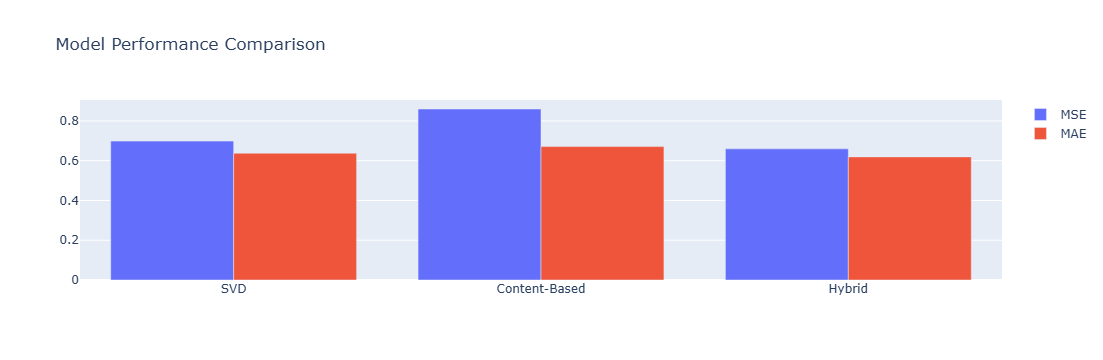

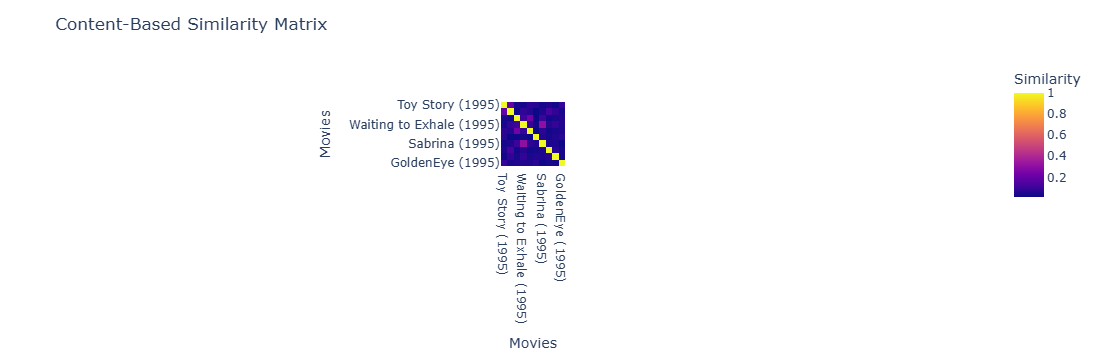

In [63]:
plot_metrics([mse_svd, mse_cb, mse_hybrid], [mae_svd, mae_cb, mae_hybrid], ['SVD', 'Content-Based', 'Hybrid'])
plot_similarity_heatmap(content_sim)

In [64]:
print("\nHybrid Predictions Sample:")
for i, (actual, hybrid, svd, cb) in enumerate(zip(actual_ratings[:10], 
                                                hybrid_preds[:10], 
                                                svd_preds[:10], 
                                                cb_predictions[:10])):
    print(f"Test {i+1}:")
    print(f"  Actual Rating: {actual:.1f}")
    print(f"  Hybrid Pred: {hybrid:.1f} (SVD: {svd:.1f} + CB: {cb:.1f})")
    print(f"  Alpha Weight: {best_alpha:.2f}*SVD + {1-best_alpha:.2f}*CB")
    print("-"*40)


Hybrid Predictions Sample:
Test 1:
  Actual Rating: 4.0
  Hybrid Pred: 3.4 (SVD: 3.4 + CB: 3.2)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 2:
  Actual Rating: 4.0
  Hybrid Pred: 4.1 (SVD: 4.1 + CB: 4.1)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 3:
  Actual Rating: 2.5
  Hybrid Pred: 3.0 (SVD: 3.1 + CB: 2.8)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 4:
  Actual Rating: 2.0
  Hybrid Pred: 3.6 (SVD: 3.6 + CB: 3.7)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 5:
  Actual Rating: 5.0
  Hybrid Pred: 3.7 (SVD: 3.7 + CB: 3.7)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 6:
  Actual Rating: 2.0
  Hybrid Pred: 2.8 (SVD: 2.5 + CB: 3.5)
  Alpha Weight: 0.70*SVD + 0.30*CB
----------------------------------------
Test 7:
  Actual Rating: 3.0
  Hybrid Pred: 2.4 (SVD: 2.1 + CB: 3.2)
  Alpha Weight: 0.70*SVD + 0.30*C

In [66]:
movie_id_to_title = movies_df.set_index('movieId')['title'].to_dict()

In [67]:
results_df = pd.DataFrame({
    'user_id': [test[0] for test in testset],
    'movie_id': [test[1] for test in testset],
    'actual_rating': actual_ratings,
    'hybrid_pred': hybrid_preds,
    'svd_pred': svd_preds,
    'cb_pred': cb_predictions
})

In [68]:
results_df['movie_title'] = results_df['movie_id'].map(movie_id_to_title)

In [69]:
print("\nHybrid Prediction Samples (First 20 Movies):")
print(results_df[['movie_title', 'actual_rating', 'hybrid_pred', 'svd_pred', 'cb_pred']]
      .head(20)
      .to_string(index=False, float_format="%.2f"))


Hybrid Prediction Samples (First 20 Movies):
                                    movie_title  actual_rating  hybrid_pred  svd_pred  cb_pred
                   2001: A Space Odyssey (1968)           4.00         3.36      3.42     3.21
               Silence of the Lambs, The (1991)           4.00         4.10      4.12     4.06
                     Color of Money, The (1986)           2.50         3.05      3.14     2.83
Mifune's Last Song (Mifunes sidste sang) (1999)           2.00         3.61      3.58     3.66
                     Breakfast Club, The (1985)           5.00         3.67      3.65     3.71
                               Fair Game (1995)           2.00         2.78      2.47     3.50
                              Thumbelina (1994)           3.00         2.42      2.09     3.20
  Lord of the Rings: The Two Towers, The (2002)           5.00         4.46      4.31     4.80
                              Phenomenon (1996)           5.00         3.91      3.99     3.70
    